In [38]:
%reload_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import csv

sys.path.append(os.path.join(os.getcwd(), os.pardir))
from plot import colorPanel, loader, stick
from plot.cd import cd
import glob
import json
#from plotting import cd
#from plotting import baseline_logger as bl

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

In [39]:
def smooth_reward_curve(x, y):
    print (len(x))
    halfwidth = min(151, int(np.ceil(len(x)/15))) # Halfwidth of our smoothing convolution
    k = halfwidth
    xsmoo = x[k:-k]
    ysmoo = np.convolve(y, np.ones(2*k+1), mode='valid') / np.convolve(np.ones_like(y), np.ones(2*k+1), mode='valid')
    downsample = max(int(np.floor(len(xsmoo)/1e3)),1)
    return xsmoo[::downsample], ysmoo[::downsample]

def process_json(path):
    with open(path, 'r') as f:
        r = {'l': [], 'r': []}
        ccnt = 0
        kk = 0
        tmp = []
        ff = 1
        lines = f.readlines()
        for line in lines[:]:
#         for line in lines[:len(lines)//2]:
            if ff:
                ff = 0
                continue
            d = json.loads(line)
            kk += d['l']
            tmp.append(d['r'])
            if kk >= 1000:
                ccnt += 1
                r['l'].append(ccnt*1000)
                kk = kk % 1000
                r['r'].append(np.mean(tmp))
                tmp = []
    for k in ['l', 'r']:
        r[k] = np.array(r[k])
    return r


def average_dict(res, keys):
    """
    :param res: the dict
    :param keys: keys
    :return: a dict with (key, (mean, std)) of results.
    """
    ret = dict()
    for k in keys:
        vs = [r[k] for r in res]
        l = min(v.shape[0] for v in vs)
        vs = [v[np.newaxis, :l] for v in vs]
        vs = np.concatenate(vs, axis=0)
#         if k == 'r':
#             vs = (vs-rr)/(er-rr)
        m, s = np.median(vs, axis=0), np.std(vs, axis=0, dtype=np.float64)
        ret[k] = [m, s]
    return ret

In [40]:
def get_data(prefix, criterion, d_type):
    with cd(prefix):
        paths = glob.glob(criterion)
        d = dict()
        print (paths, criterion)
        print (len(paths))
        for path in paths:
#             files = glob.glob(path + '/seed-*/*.monitor.json')
            res = []
#             for f in files:
#                 if 'seed-14/' in f or 'seed-1/' in f or 'seed-6/' in f:
#                     continue
#                 print (f)
            r = process_json(path)
            res.append(r)
            print (len(res))
            if True:
                res = average_dict(res, ['l', 'r'])
            d[path] = res
        #print (path)        
#         print ("len is %d"%(len(paths)))
#         for k, v in d.items():
#             print (k)
#         abc
        if len(paths) == 1:
            for k, v in d.items():
                return v
        else:
            return d

In [51]:
def plotArg(game, ax):
    env_id, traj_need = game.split('-')
    colors = colorPanel.colorPanel(1).getColors()
    d_type = ['cotrain']#, 'centralized']
    cnt = 0
    hyper = ["l-0.0003-b-2048-dc-1-di-5-na-3-bs-3"]
    seed = ['seed-5']
    poten = []
    num = []
    cnt_color = [1,colors[4],colors[0],colors[5],colors[1],colors[7]]
    for i in hyper:
        for j in seed:
              poten.append('%s/%s'%(i,j))
    for i in poten:
        num.append(int(i.split('-')[-4]))
    for i in range(len(d_type)):
        for j in range(len(poten)):
            for k in range(num[j]):
#             for k in range(1,3):
                datas = get_data(prefix='/atlas/u/hyren/VLAEGAIL/DCGAN-tensorflow/imitation/logs/exps/', 
                                  criterion='%s/%s/%s/monitor%d.*'%(d_type[i], game, poten[j], k), d_type=num[j])
                print ('GET!: %s/%s/%s/%d.json'%(d_type[i],game,poten[j],k))
                label = '%s' % (k)
                x = datas['l']
                y = datas['r']
                x = x[0]
                y_mean = y[0]
                y_std = y[1]
                xx = x
                x, y_mean = smooth_reward_curve(xx, y_mean)
                x, y_std = smooth_reward_curve(xx, y_std)
                x = x * 1e7 / np.max(x)
                cnt += 1
                color = cnt_color[cnt]

#                 if cnt == 1:
#                     color = colors[4]
#                 elif cnt == 2:    
#                     color = colors[0]
#                 elif cnt == 3:
#                     color = colors
                y_upper = y_mean + y_std
                y_lower = y_mean - y_std
                ax.fill_between(
                    x, list(y_lower), list(y_upper), interpolate=True, facecolor=color, linewidth=0.0, alpha=0.3
                )
                line = ax.plot(x, list(y_mean), label=label, color=color, rasterized=True)          

    game = 'Walker2d'
    stick.cutsomStick(game, 'timesteps', ax)
    if args == 'Reacher-v1':
        ax.set_ylim(-30, 0)
    #ax.set_ylim(-70,0)

Walker2d-v1
(['cotrain/Walker2d-v1/l-0.0003-b-2048-dc-1-di-5-na-3-bs-3/seed-5/monitor0.json.monitor.json'], 'cotrain/Walker2d-v1/l-0.0003-b-2048-dc-1-di-5-na-3-bs-3/seed-5/monitor0.*')
1
1
GET!: cotrain/Walker2d-v1/l-0.0003-b-2048-dc-1-di-5-na-3-bs-3/seed-5/0.json
6926
6926
(['cotrain/Walker2d-v1/l-0.0003-b-2048-dc-1-di-5-na-3-bs-3/seed-5/monitor1.json.monitor.json'], 'cotrain/Walker2d-v1/l-0.0003-b-2048-dc-1-di-5-na-3-bs-3/seed-5/monitor1.*')
1
1
GET!: cotrain/Walker2d-v1/l-0.0003-b-2048-dc-1-di-5-na-3-bs-3/seed-5/1.json
6927
6927
(['cotrain/Walker2d-v1/l-0.0003-b-2048-dc-1-di-5-na-3-bs-3/seed-5/monitor2.json.monitor.json'], 'cotrain/Walker2d-v1/l-0.0003-b-2048-dc-1-di-5-na-3-bs-3/seed-5/monitor2.*')
1
1
GET!: cotrain/Walker2d-v1/l-0.0003-b-2048-dc-1-di-5-na-3-bs-3/seed-5/2.json
6923
6923


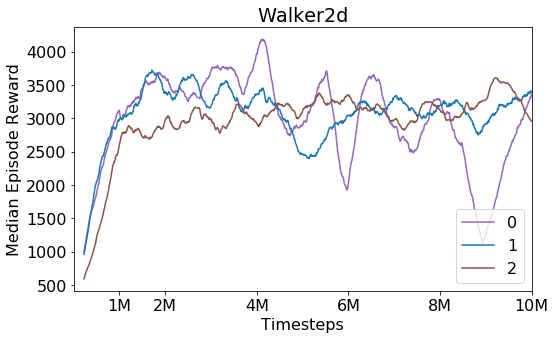

In [52]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
columns = 1
sixAtariGames = [
    'Walker2d-v1',
]

for i, args in enumerate(sixAtariGames):
    print(args)
    #ax = fig.add_subplot(len(sixAtariGames) / columns + 1, columns, i + 1)
    #ax = fig.add_subplot(1, 1, 1)
    plotArg(args, ax)

plt.legend(loc=4)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Median Episode Reward')

fig.tight_layout()
# fig.savefig('reacher.pdf', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('co-wa-5.pdf', dpi=300)